# Project 2 – Linear and Nonlinear Solvers
## MATH 3316 High Performance Scientific Computing, Fall 2016

Author: Paul Herz

The designated programming language for this project was C++, built in Xcode and compiled with Clang (Apple LLVM 8.0.0) using the C++14 dialect.

### Structure of this Project

This project's file structure follows the GNU-style C++ project standard.

In [76]:
%ls ..

HPSCProject2.xcodeproj/ data/                   reports/
Makefile                lib/                    src/
bin/                    notebooks/


Excluding the `.xcodeproj` file, which was used for integration with the Xcode IDE, debugging, and profiling purposes, each item in the project directory serves the following purpose:

- `Makefile`: GNU Make project build automation definitions
- `bin/`: compiled binaries. Make will put binaries here by default.
- `data/`: where calculated data is stored after program execution. Files are `.txt` files containing real numbers, space delimited to denote row items, and newline delimited to denote new rows. Some data files, whose names end in `_out`, are just piped output from program execution and follow no specific format.
- `lib/`: reused libraries that are not part of this project specifically. Contains my rewrite of the Matrix library ([phrz/matrix](https://github.com/phrz/matrix)).
- `notebooks/`: Python 3 Jupyter notebooks, notably the one used to generate this report.
- `reports/`: PDFs generated from the Jupyter notebooks via `nbconvert` and `pdflatex`.
- `src/`: contains the main mathematical routines described in this report, which are used to generate the data and redirected output in `data/`.

### Using this Project

#### Prerequisites
- A Unix or Unix-like OS (e.g. macOS or Linux)
- A compiler with support for C++14 (LLVM or GNU toolchain)
- Python ≥3.5
- The latest Jupyter distribution
- LaTeX with `pdflatex`
- GNU Make ≥3.81

#### Building this project
This project provides several GNU Make targets, with a handful of them being especially useful.

`make all` (default) - will compile binaries, execute them to generate data files, execute Jupyter notebooks under fresh kernels with just-generated data files, and convert them to PDFs in `/reports`.

`make all_bin` - will compile binaries for parts A, B, and C (`vandermonde`, `newton`, and `kepler`) of this project.

`make all_data` - will compile binaries and execute them to generate data files.

`make clean` - will delete all compiled binaries, generated data, executed notebook copies (but not the original notebooks), and **report PDFs**.

Below, find attached the full Makefile:

In [77]:
%cat ../Makefile

#
#  Makefile
#  HPSCProject2
#
#  Created by Paul Herz on 10/4/16.
#  Copyright © 2016 Paul Herz. All rights reserved.
#

TARGETA = vandermonde
TARGETB = test_newton
TARGETC = kepler

CXX = g++
CFLAGS = -std=c++14

SRC = src/
LIB = lib/
BIN = bin/
ROOT = $(shell pwd)/
DATA = data/
NB = notebooks/
RP = reports/

AFILES = vandermonde.cpp
BFILES = test_newton.cpp
CFILES = kepler.cpp
LIBFILES = Vector.cpp Matrix.cpp

NOTEBOOK = $(NB)proj2.ipynb
REPORT = $(RP)proj2.pdf



################################
# All target                   #
################################

all: all_bin all_data all_reports



################################
# Application binaries         #
################################

all_bin: $(TARGETA) $(TARGETB) $(TARGETC)

$(TARGETA):
	$(CXX) $(CFLAGS) -o $(BIN)$(TARGETA) -I $(LIB) $(addprefix $(LIB), $(LIBFILES)) $(addprefix $(SRC), $(AFILES))

$(TARGETB):
	$(CXX) $(CFLAGS) -o $(BIN)$(TARGETB) -I $(LIB) $(addprefix $(LIB), $(LIBFILES)) $(addprefix $(SRC), $(BFILES)

## Part A – Vandermonde Matrices

Part A of this project concerned itself with the definition of Vandermonde matrices, implementing them programmatically (namely, their generation given certain parameters), and their deleterious nature in solving linear systems with Gaussian elimination.

### Goals

I needed to begin this project with an algorithm to generate Vandermonde matrices from an initial column vector of size $n$. When my program was asked to generated an $n^{th}$ degree Vandermonde matrix, it needed to first generate a column vector $\mathbf{v}$ consisting of a linear span from $0\ldots 1$ from $v_0\ldots v_{n-1}$. This would be used as the columns of the Vandermonde matrix pre-exponentiation. I would then generate the vector $\mathbf{x}$ of degree $n$ with a uniformly random distribution.

### Math Background

#### Vandermonde Matrix

A Vandermonde matrix is a pathologically exemplary ill-conditioned matrix defined as a degree $n$ matrix whose columns are based upon a single $n$-sized column vector $\mathbf{v}$, such that for each element of the matrix $a_{ij}$, $a_{ij}={v_i}^{j-1}$ (assuming one-indexing)

#### Error Vector

The error vector is the absolute value of the elementwise difference of the true solution $\mathbf{x}$ and the Gaussian solution $\hat{\mathbf{x}}$, or $\vec{\epsilon}=|\mathbf{x}-\hat{\mathbf{x}}|$. The *error* is a scalar defined as the two-norm of this error vector.

#### Residual Vectors

For a linear system $\mathbf{A}\mathbf{x}=\mathbf{b}$, the solution found through Gaussian elimination $\hat{\mathbf{x}}$ has inherent error relative to the "true" $\mathbf{x}$, which can be represented through the absolute error function $|\mathbf{A}\hat{\mathbf{x}} - \mathbf{A}\mathbf{x}|$, which through substitution is $|\mathbf{A}\hat{\mathbf{x}} - \mathbf{b}|$. The *residual* is a scalar defined as the two-norm of this residual vector.

#### Two Norm

For a column vector $\mathbf{x}$, of size $n$ and containing elements $x_0\ldots x_{n-1}$, the two norm is the result of the expression: 
$$\left( \sum_{0}^{n-1} {x_i}^2 \right)^{1/2}$$

### Implementation Requirements

#### Vandermonde Methods and the Matrix Library

I was required to create a file called `vandermonde.cpp` whose main method would iterate the array $5, 9, 17, 33, 65$, and for each such value, create a Vandermonde matrix $\mathbf{A}$ of that degree, and with a randomly-generated $\mathbf{x}$ vector, attempt to solve it. Following that, I was to perform quantitative error analysis by means of the error and residual scalars for the linear system. The purpose of this exercise was to reveal the ill-conditioned nature of the Vandermonde matrix, and the behavior of linear systems involving such a matrix over increasing degree $n$. The matrix library functions to be used for (1) the linear span of $\mathbf{v}$, the source material for the Vandermonde matrices, (2) the uniform random distribution of $\mathbf{x}$, and (3) the solution of the resultant linear system are `Matrix::linSpace`, `Matrix::random`, and `Matrix::linearSolve`. Note that I am using a custom-rolled variant of the matrix library, of my own design — API calls will vary from the anticipated names.

### Implementation

#### Vandermonde Methods and the Matrix Library

For the sake of simplicity, legibility, and conciseness, I wrote the main routine of this program as a loop over the given array of $n$ values. Within the loop, I generated `Vector v` as a linear span, `Vector x` as a random vector, and `Matrix A` as the result of my `makeVandermonde` method, which clearly delineates the concerns of calculation in this exercise. `makeVandermonde` simply uses my `Matrix` class's `mapElements` function to render the aforementioned mapping
$$
a_{ij}={v_{i}}^{j-1}
$$
Although with zero-indexing, as it is performed in the actual code, the formula is
$$
a_{rc}={v_{r}}^{c}
$$

In [1]:
%cat ../src/vandermonde.cpp

//
//  vandermonde.cpp
//  HPSCProject2
//
//  Created by Paul Herz on 9/21/16.
//  Copyright © 2016 Paul Herz. All rights reserved.
//

#include "Matrix.h"
#include "Vector.h"
#include "println.cpp"

using namespace PH;

Matrix makeVandermonde(Vector v) {
	// The Vandermonde matrix of order n is an (n,n) matrix is defined as
	// A(r,c) = v[r] ^ c (assuming zero indexing!)
	
	Matrix vandermonde = Matrix(v.size(), v.size());
	
	vandermonde.mapElements([&](double& element, Index r, Index c) {
		element = std::pow(v[r], c);
	});
	
	return vandermonde;
}

int main(int argc, const char * argv[]) {
	
	// Solve a linear system Ax=b with a Vandermonde A of order n
	// for each n = 5, 9, 17, 33, 65.
	for(auto n : {5, 9, 17, 33, 65}) {
		
		println("n =",n,":");
		
		// To generate the matrix, use vector v with an n-size linear span
		// 0...1 (inclusive), and vector x with n random entries.
		
		Vector v = Vector::linSpace(0, 1, n);
		Vector x = Vector::random(n);
		
		Matrix A = makeVandermond

After generating the $n^{th}$ degree Vandermonde matrix $\mathbf{A}$, all that's left is to perform Gaussian elimination to solve the system $\mathbf{A}\mathbf{x}=\mathbf{b}$ to calculate the approximate value $\hat{\mathbf{x}}$. Note that I produce copies of `A` and `b` — this is due to a quirk of the `Matrix` library remnant of its original design: although not apparent, `A` and `b` are modified in place when passed to `Matrix::linearSolve`. After that, error calculation is performed by generating the error vector as the elementwise operation $\vec{\epsilon}=|\hat{\mathbf{x}} - \mathbf{x}|$, essentially producing a vector of the elementwise relative error of $\hat{\mathbf{x}}$ in approximating $\mathbf{x}$. I display the two-norm of this error vector (the error scalar) using the inbuilt `Vector::norm` method (note that my `Matrix` library includes a distinct `Vector` class, to more closely approximate the familiar behavior of MATLAB). I also calculate the residual vector as the elementwise relative error of $\hat{\mathbf{b}}=\mathbf{A}\hat{\mathbf{x}}$ in approximating $\mathbf{b}$. Similarly, a residual scalar is generated and displayed. No file manipulation for persistence is performed here, but execution output was piped to a file for demonstrative purposes:

#### Output

In [3]:
%cat ../data/a_out.txt

n = 5 :
  • Error vector 2-norm: 5.88887
  • Residual vector 2-norm: 56.0704
-------------------------------
n = 9 :
  • Error vector 2-norm: 5.70762
  • Residual vector 2-norm: 135.004
-------------------------------
n = 17 :
  • Error vector 2-norm: 32.8802
  • Residual vector 2-norm: 2193.44
-------------------------------
n = 33 :
  • Error vector 2-norm: 93.985
  • Residual vector 2-norm: 17442.5
-------------------------------
n = 65 :
  • Error vector 2-norm: 154.871
  • Residual vector 2-norm: 79948.9
-------------------------------


### Analysis

Due to the exemplary ill-conditioned nature of the Vandermonde matrix, it isn't surprising to find that the error of the result $\hat{\mathbf{x}}$, or the error of the product approximation $\hat{\mathbf{b}}$ (residual) demonstrate runaway behavior as the degree of the matrix increases — to such extent that the results Gaussian elimination become practically useless for most larger matrices of this variety. An ill-conditioned matrix is formally defined as a matrix having a high condition number, which is a calculated value quantifying the "instability" of a linear system, i.e. how susceptible a system is to significant changes in solution given slight modifications (perturbations). Notice how as $n$ increases, the error scalar seems to increase in a more linear fashion, and thus the quality of the approximation of $\mathbf{x}$ decreases in a linear fashion. But then notice how rapidly the residual scalar demonstrates a much more "runaway" effect — it should be noted that in an ill-conditioned system, the residual **cannot** be depended upon as a quantitative metric of system solution accuracy — so despite the outrageous numbers, this is only a side effect of the ill-conditioned system.

## Part A – Newton's Method

Project 2 Part B focused on root finding with Newton's method, 

### Goals

I needed to begin this project with an algorithm to generate Vandermonde matrices from an initial column vector of size $n$. When my program was asked to generated an $n^{th}$ degree Vandermonde matrix, it needed to first generate a column vector $\mathbf{v}$ consisting of a linear span from $0\ldots 1$ from $v_0\ldots v_{n-1}$. This would be used as the columns of the Vandermonde matrix pre-exponentiation. I would then generate the vector $\mathbf{x}$ of degree $n$ with a uniformly random distribution.

### Math Background

#### Vandermonde Matrix

A Vandermonde matrix is a pathologically exemplary ill-conditioned matrix defined as a degree $n$ matrix whose columns are based upon a single $n$-sized column vector $\mathbf{v}$, such that for each element of the matrix $a_{ij}$, $a_{ij}={v_i}^{j-1}$ (assuming one-indexing)

#### Error Vector

The error vector is the absolute value of the elementwise difference of the true solution $\mathbf{x}$ and the Gaussian solution $\hat{\mathbf{x}}$, or $\vec{\epsilon}=|\mathbf{x}-\hat{\mathbf{x}}|$. The *error* is a scalar defined as the two-norm of this error vector.

#### Residual Vectors

For a linear system $\mathbf{A}\mathbf{x}=\mathbf{b}$, the solution found through Gaussian elimination $\hat{\mathbf{x}}$ has inherent error relative to the "true" $\mathbf{x}$, which can be represented through the absolute error function $|\mathbf{A}\hat{\mathbf{x}} - \mathbf{A}\mathbf{x}|$, which through substitution is $|\mathbf{A}\hat{\mathbf{x}} - \mathbf{b}|$. The *residual* is a scalar defined as the two-norm of this residual vector.

#### Two Norm

For a column vector $\mathbf{x}$, of size $n$ and containing elements $x_0\ldots x_{n-1}$, the two norm is the result of the expression: 
$$\left( \sum_{0}^{n-1} {x_i}^2 \right)^{1/2}$$

### Implementation Requirements

#### Vandermonde Methods and the Matrix Library

I was required to create a file called `vandermonde.cpp` whose main method would iterate the array $5, 9, 17, 33, 65$, and for each such value, create a Vandermonde matrix $\mathbf{A}$ of that degree, and with a randomly-generated $\mathbf{x}$ vector, attempt to solve it. Following that, I was to perform quantitative error analysis by means of the error and residual scalars for the linear system. The purpose of this exercise was to reveal the ill-conditioned nature of the Vandermonde matrix, and the behavior of linear systems involving such a matrix over increasing degree $n$. The matrix library functions to be used for (1) the linear span of $\mathbf{v}$, the source material for the Vandermonde matrices, (2) the uniform random distribution of $\mathbf{x}$, and (3) the solution of the resultant linear system are `Matrix::linSpace`, `Matrix::random`, and `Matrix::linearSolve`. Note that I am using a custom-rolled variant of the matrix library, of my own design — API calls will vary from the anticipated names.

### Implementation

#### Vandermonde Methods and the Matrix Library

For the sake of simplicity, legibility, and conciseness, I wrote the main routine of this program as a loop over the given array of $n$ values. Within the loop, I generated `Vector v` as a linear span, `Vector x` as a random vector, and `Matrix A` as the result of my `makeVandermonde` method, which clearly delineates the concerns of calculation in this exercise. `makeVandermonde` simply uses my `Matrix` class's `mapElements` function to render the aforementioned mapping
$$
a_{ij}={v_{i}}^{j-1}
$$
Although with zero-indexing, as it is performed in the actual code, the formula is
$$
a_{rc}={v_{r}}^{c}
$$

In [78]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({
        'font.family': 'Helvetica, Arial, sans-serif'
})

%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [84]:
names = ['t','x','y']
v = {}
for name in names:
    v[name] = loadtxt('../data/' + name + '.txt')

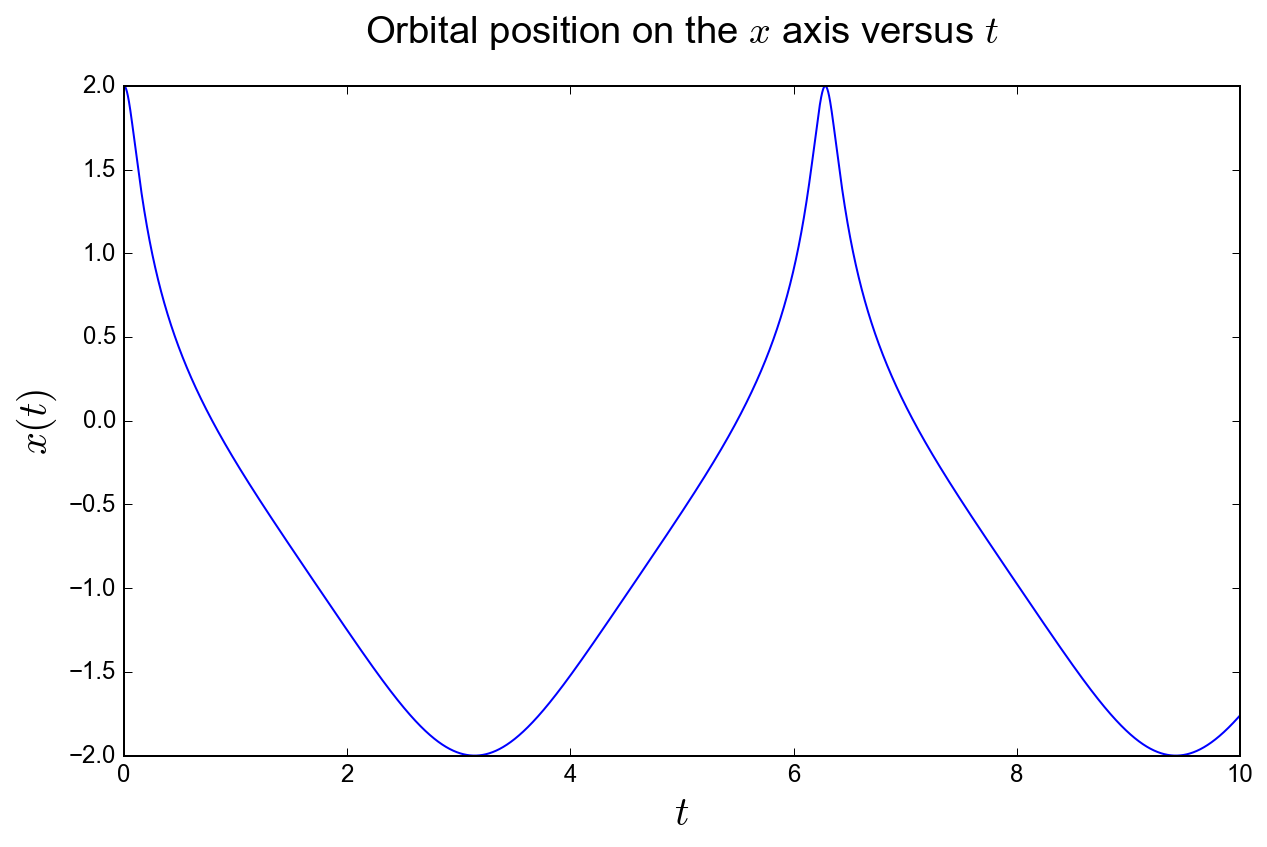

In [81]:
# Create three plots:
# 1. x(t) vs t

pylab.plot(v['t'], v['x'])

pylab.xlabel('$t$')
pylab.ylabel('$x(t)$')
pylab.title('Orbital position on the $x$ axis versus $t$', y=1.05)

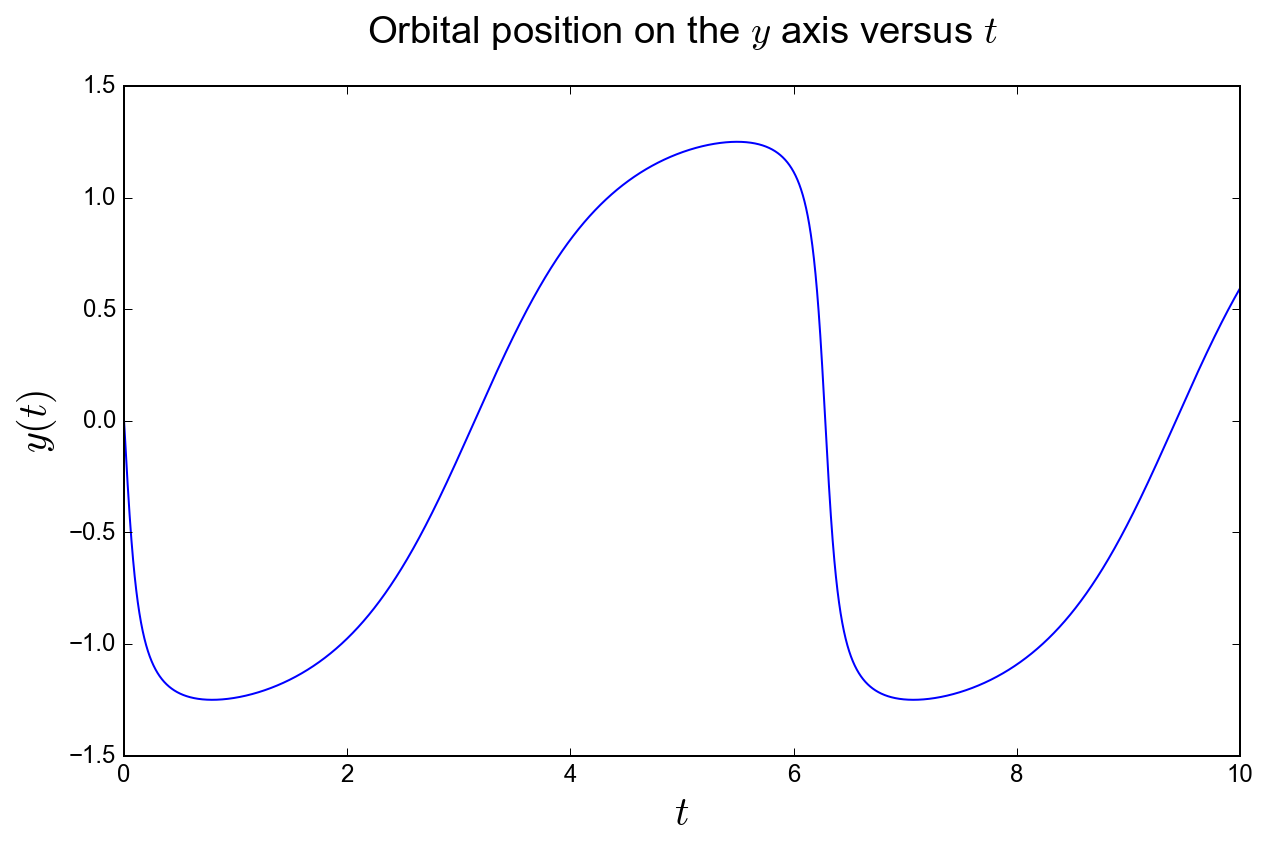

In [82]:
# 2. y(t) vs t

pylab.plot(v['t'], v['y'])

pylab.xlabel('$t$')
pylab.ylabel('$y(t)$')
pylab.title('Orbital position on the $y$ axis versus $t$', y=1.05)

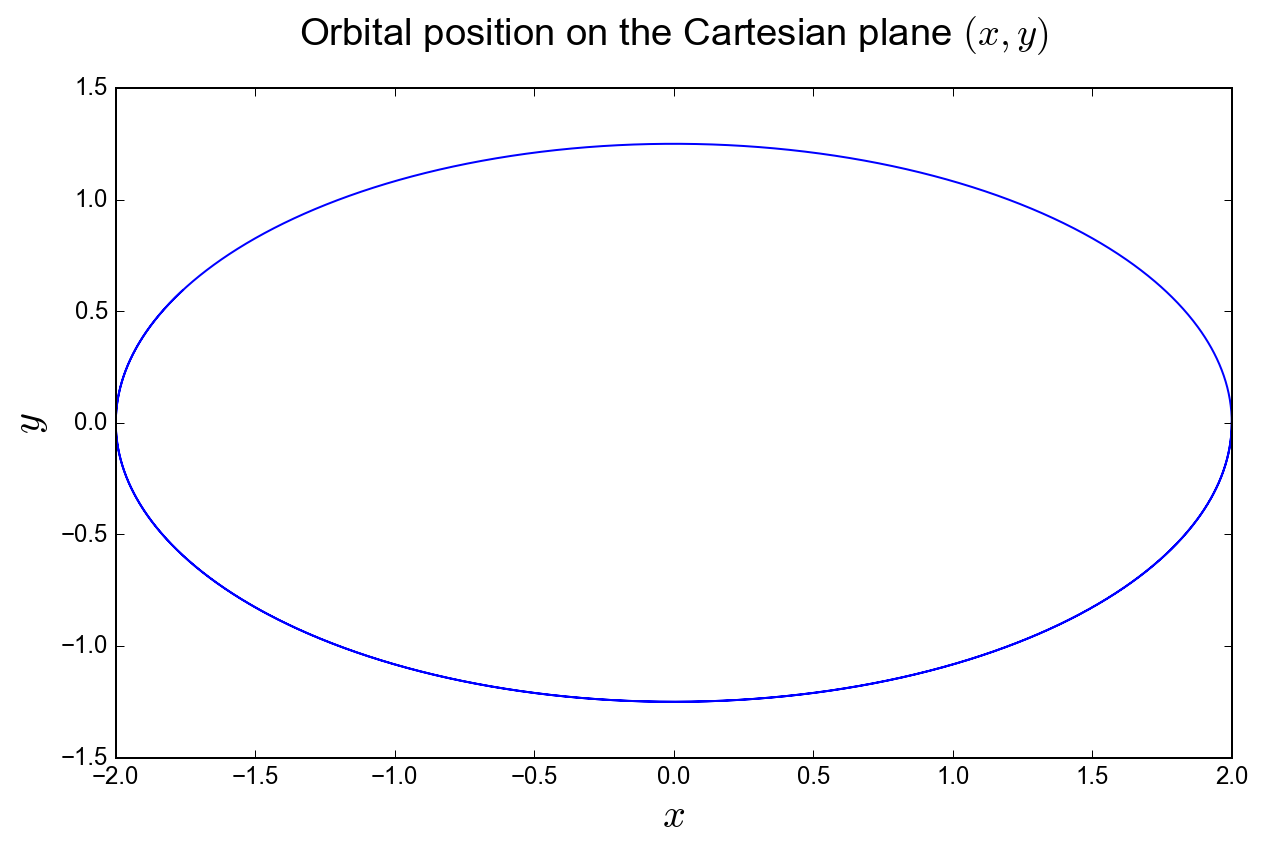

In [83]:
# 3. y(t) vs x(t)

pylab.plot(v['x'], v['y'])

pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.title('Orbital position on the Cartesian plane $(x,y)$', y=1.05)